<a href="https://colab.research.google.com/github/Jasper-Hewitt/privatestuff/blob/main/Shanshan_Twitter_predict_unlabelled_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

In [1]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 1.9 MB/s 
     |████████████████████████████████| 182 kB 67.2 MB/s 
     |████████████████████████████████| 212 kB 55.8 MB/s 
     |████████████████████████████████| 132 kB 59.7 MB/s 
     |████████████████████████████████| 127 kB 61.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 16.3 MB/s 
     |████████████████████████████████| 7.6 MB 67.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 49 kB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Uninsta

In [2]:
#import our model from huggingface
number_classes = 2
model_tokenizer = "hfl/chinese-bert-wwm"

if number_classes == 2:
    model_classifier = "owen198/weibo-wmmbert-2"
else:
    model_classifier = "owen198/weibo-wmmbert-6"


In [3]:
model_classifier

'owen198/weibo-wmmbert-2'

# 1. load and clean data

In [4]:
#insert new xlsx file here
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/challange/scrap_shanshan.xlsx

--2022-12-09 07:14:44--  https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/challange/scrap_shanshan.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 410939 (401K) [application/octet-stream]
Saving to: ‘scrap_shanshan.xlsx’

scrap_shanshan.xlsx 100%[===================>] 401.31K  --.-KB/s    in 0.007s  

2022-12-09 07:14:44 (59.3 MB/s) - ‘scrap_shanshan.xlsx’ saved [410939/410939]



In [5]:
import pandas as pd

In [6]:
#insert new xlsx file here
testing_pd = pd.read_excel('/content/scrap_shanshan.xlsx')
testing_pd = testing_pd[['Text']]
testing_pd = testing_pd.rename(columns={'Text':'text'})

In [7]:
#dirty data
testing_pd

,text
0,FelixChang 台灣獨立建國志願軍\n@FelixCh29980680\n·\n42m...
1,FelixChang 台灣獨立建國志願軍\n@FelixCh29980680\n·\n1h對...
2,Bruce Kuo\n@kuo1912\n·\n7hReplying to \n@i_don...
3,肯尼不啃泥\n@i_dont_care_004\n·\n8 Dec喔我確定那個男的是白粉，因...
4,ChenChen\n@Chen57962136\n·\n7 Dec[https://twit...
...,...
1683,Need a Drink\n@KmtEnemy\n·\n31 Oct林洲民基本上是我最討厭的...
1684,台灣推新聞\n@mytwnews\n·\n31 Oct嗆蔣萬安搞不清內湖科學園區狀況 黃珊珊...
1685,逆轟高灰\n@IloveROCTW\n·\n31 OctReplying to \n@byj...
1686,lemondemon\n@lemondemon\n·\n31 Oct轉噗 不來恩: 接到電話...


In [8]:
#we can consider not deleting the titles. This will be up to the ICI project group to decide
#if you wish to preserve the titles. replace the corresponding block of code below with this one 

#testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True)#.replace(title_pattern_1,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
##testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
#________________________________________________________________________________________________________________________

testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]


import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
#title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'
twitter_username='@([A-Za-z0-9_]+)'
letters='[A-z]'
newline_symbols='/\r?\n|\r/'
numbers='[0-9]'

#replace with this block. Do some more research because it looks like some titles are still removed, like index 41
testing_pd['text'] = testing_pd['text'].replace(twitter_username,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(letters,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(newline_symbols,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(numbers,'',regex=True)

In [9]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['text']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,text
0,台灣獨立建國志願軍\n\n·\n \n\n那陳時中可以去控告周玉蔻啊！\n他這時不告，什...
1,"台灣獨立建國志願軍\n\n·\n對手罵陳時中""謀財害命""，他不提告；\n對手抹黑陳時中和周..."
2,\n\n·\n \n\n黃珊珊也沒結婚吧
3,肯尼不啃泥\n\n·\n 喔我確定那個男的是白粉，因為他就是在我面前對我說「我好希望是黃珊珊...
4,\n\n·\n \n宅神說敗而不潰\n黃珊珊及台灣民眾黨要快點有各種社群系統互動\n\n感想...
...,...
1683,\n\n·\n 林洲民基本上是我最討厭的人之一，但只要問對問題，不惡意攻擊，我們不是都要...
1684,台灣推新聞\n\n·\n 嗆蔣萬安搞不清內湖科學園區狀況 黃珊珊：難怪政策常出笑話 - 自由...
1685,逆轟高灰\n\n·\n \n\n之前黃珊珊在北市大辦被轟，但是國中小辦沒問題，講好就好，...
1686,\n\n·\n 轉噗 不來恩: 接到電話唯一支持黃珊珊~ ()\n\n \n.\n接到電...


## 1-2 Tokenization

In [10]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [11]:
from transformers import AutoTokenizer

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [14]:
full_test_dataset = tokenized_datasets["test"]

# 2. preparing BERT


In [15]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=2)

Downloading:   0%|          | 0.00/909 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/409M [00:00<?, ?B/s]

In [16]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-16-e1ee7db0da93>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

In [18]:
import numpy as np

#prediction results


In [19]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1688
  Batch size = 8


In [20]:
pred

PredictionOutput(predictions=array([[ 2.412252  , -3.5054924 ],
       [ 1.5599163 , -1.9608803 ],
       [ 2.40375   , -3.4813962 ],
       ...,
       [ 0.18889715,  0.40859714],
       [-2.035315  ,  2.1194098 ],
       [ 2.475688  , -3.6674654 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 59.3223, 'test_samples_per_second': 28.455, 'test_steps_per_second': 3.557})

In [21]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([0, 0, 0, ..., 1, 1, 0])

In [22]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [23]:
#final table. Remember, 0 = negative, 1 = positive
testing_pd

,text,pred
0,台灣獨立建國志願軍\n\n·\n \n\n那陳時中可以去控告周玉蔻啊！\n他這時不告，什...,0
1,"台灣獨立建國志願軍\n\n·\n對手罵陳時中""謀財害命""，他不提告；\n對手抹黑陳時中和周...",0
2,\n\n·\n \n\n黃珊珊也沒結婚吧,0
3,肯尼不啃泥\n\n·\n 喔我確定那個男的是白粉，因為他就是在我面前對我說「我好希望是黃珊珊...,1
4,\n\n·\n \n宅神說敗而不潰\n黃珊珊及台灣民眾黨要快點有各種社群系統互動\n\n感想...,0
...,...,...
1683,\n\n·\n 林洲民基本上是我最討厭的人之一，但只要問對問題，不惡意攻擊，我們不是都要...,0
1684,台灣推新聞\n\n·\n 嗆蔣萬安搞不清內湖科學園區狀況 黃珊珊：難怪政策常出笑話 - 自由...,0
1685,逆轟高灰\n\n·\n \n\n之前黃珊珊在北市大辦被轟，但是國中小辦沒問題，講好就好，...,1
1686,\n\n·\n 轉噗 不來恩: 接到電話唯一支持黃珊珊~ ()\n\n \n.\n接到電...,1


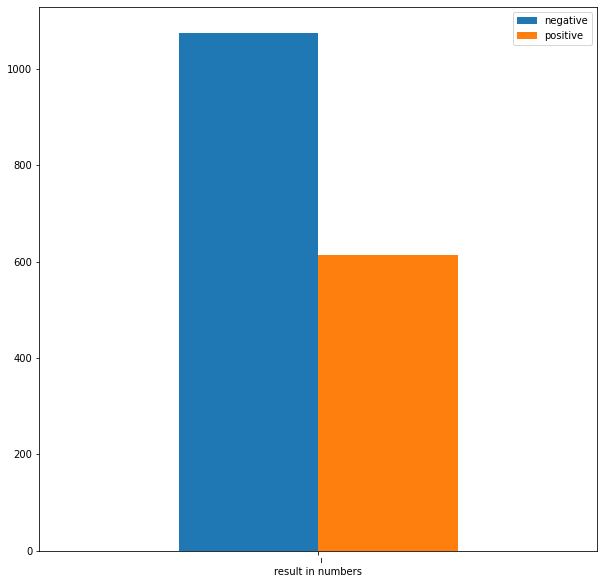

In [24]:
#plot in total amounts. Remember, 0 = negative, 1 = positive
import pandas as pd
import matplotlib.pyplot as plt
count0 = (testing_pd['pred'] == 0).sum()
count1 = (testing_pd['pred'] == 1).sum()
df_plot=pd.DataFrame({'result in numbers': ['_'], 'negative':[count0], 'positive': [count1]})
df_plot.plot.bar(x='result in numbers', figsize=(10, 10))
plt.show()

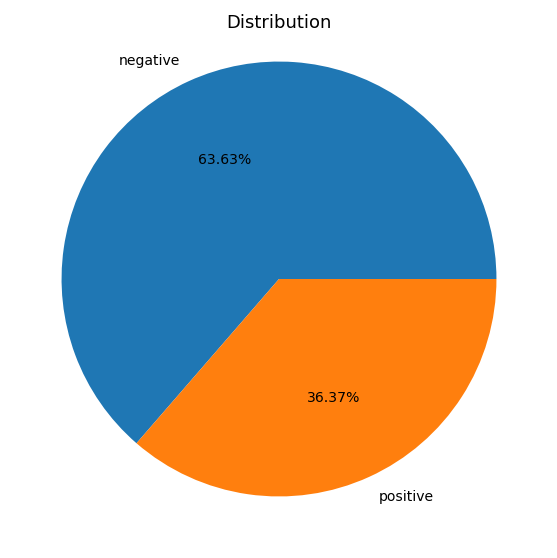

In [25]:
#plot in percentage. Remember, 0 = negative, 1 = positive
def Percentage(num1, num2):
    return num1 / (num1 + num2) * 100

per1=Percentage(count0, count1)
per2=Percentage(count1, count0)

label = ['negative', 'positive']
shares = [per1, per2]
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(shares, labels=label, autopct='%.2f%%', shadow=False, labeldistance=1.1,  textprops={'fontsize': 14})
ax.set_title('Distribution', fontsize=18, y=0.95);